# Task 2 Word2Vec with Keras Gensim SkipGram

In [1]:
import io
import re
import os
import nlp
import ast
import random
import string
import shutil
import pathlib
import itertools
import contractions
import tensorflow_text

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [3]:
from tqdm import tqdm
from time import sleep
from textblob import TextBlob 
from textblob import Word
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer  
from official.nlp import optimization
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
import gensim.models
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Path configuration

In [4]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
data_path               = os.path.join(parent_path, "01-Data/PubMed_20k_RCT_numbers_replaced_with_at_sign/")
model_path_parent       = os.path.join(parent_path, "03-Models/")
tensorboard_path_parent = os.path.join(parent_path, "04-Logs/03-Task3")

## Parameter Settings

In [5]:
# Gensim and Classifier similar https://towardsdatascience.com/multiclass-text-classification-using-keras-to-predict-emotions-a-comparison-with-and-without-word-5ef0a5eaa1a0
dataset_name    = 'pubmed20k'
model_name      = 'word2vec_skipgram'

#If you want to reduce the training set to acclerate the training->giving worse results
train_samples   = -1    #Reduce if want to work with smaller dataset
val_samples     = -1   #Reduce train_validation time to long
test_samples    = -1    #Adjust to reduce evaluation time


batch_size        = 1024       #Reduce if memory usage to high
# steps_per_epoch = 1000    #Influences total trainings  steps with it the learning rate and optimizer
# epochs          = 100


In [6]:
ps = PorterStemmer()
lm = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)

def remove_punctuation(text):
    return " ".join([word for word in str(text).split() if word not in string.punctuation])
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])
def lemmatize_words(text):
    return " ".join([lm.lemmatize(word) for word in text.split()])
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
def remove_numbers(text):
    return ''.join(c for c in text if not c.isdigit())
def spell_check(text):
    print(text)
    return ''.join(TextBlob(x).correct() for x in text)
def remove_freqwords(text,freqwords):
    return " ".join([word for word in str(text).split() if word not in freqwords])
def remove_rarewords(text,rarewords):
    return " ".join([word for word in str(text).split() if word not in rarewords])


In [7]:
# Read in pubmed data files 
def get_lines(filename):
    with open(filename, "r") as f:    
        return f.readlines()
    
    
# Plotting Confusion Matrix   
def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    
    
# Confusion Matrix Callback for Keras
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(np.array(padded_val))
    test_pred = np.argmax(test_pred, axis=-1)
    classes = [*class_to_index]
    cm = metrics.confusion_matrix(val_labels, test_pred)
    normalize = True
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix "+model_name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)

# Preparing data
def prepare_text(filename):
    """Returns a pandas dataframe.
    
    Reads filenames, its contents, seperates labels and text, lower text, remove_punctuation
    tokenize,remove stopwords,stemming and lemmatize

    Args:
        filename

    Returns:
        pd.dataframe

    """
    input_lines = get_lines(filename)
    abstract_lines = "" 
    abstract_dict_list = [] 
    token_list = []
    label_list = []
    for line in tqdm(input_lines):
        if line.startswith("###"): # check if new ID
            abstract_lines = "" #simple reset
        elif line.isspace(): # if new line?
            splitted_abstract_lines = abstract_lines.splitlines() # split abstract into separate lines
            for split_line in splitted_abstract_lines:
                abstract_dict = {} # create dict for easy df transfer
                split = split_line.split("\t") # split label from text with \t
                text  = contractions.fix(split[1].lower())
                text  = remove_punctuation(text)
                tokens  = remove_stopwords(text.split())
                tokens  = stem_words(tokens)
                tokens  = lemmatize_words(tokens)
                token_list.append(ast.literal_eval(tokens))
                label_list.append(split[0])
        else: 
            abstract_lines += line
    df = pd.DataFrame({"split":token_list,"labels":label_list})
    return df

In [9]:
# # Dataframes (can take a while 1-2 mins for me, or 20 with big dataset)
# df_train = prepare_text(data_path + "train.txt")
# df_val   = prepare_text(data_path + "dev.txt")
df_test  = prepare_text(data_path + "test.txt")

100%|██████████| 35135/35135 [00:15<00:00, 2196.64it/s]


In [10]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def untokenize(df):
    df["text"] = df["split"].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
    return df


In [12]:
# df_train = untokenize(df_train)
# df_val   = untokenize(df_val)
df_test  = untokenize(df_test)

In [13]:
import nltk
from nltk.tokenize import word_tokenize

# tokenized_train_features = [word_tokenize(each_train_text) for each_train_text in df_train.text]
# tokenized_val_features = [word_tokenize(each_val_text) for each_val_text in df_val.text]
tokenized_test_features = [word_tokenize(each_test_text) for each_test_text in df_test.text]

In [16]:
#Helper dicts with relationships and inverse relationships
classes            = set(df_test.labels.tolist())
class_to_index     = dict((c,i) for i, c in enumerate(classes))
index_to_class     = dict((v,k) for k, v in class_to_index.items())
names_to_ids       = lambda labels: np.array([class_to_index.get(x) for x in labels])
# train_labels = names_to_ids(df_train.labels.tolist())
# val_labels   = names_to_ids(df_val.labels.tolist())
test_labels  = names_to_ids(df_test.labels.tolist())

In [20]:
from gensim.models import word2vec
# We set wordembeddings to max length 300
#config
vector_size = 50

# Set sg=1 to make skip-gram
w2v_model = word2vec.Word2Vec(
    tokenized_test_features[0:300],
    vector_size=vector_size,  # Dimensionality of the word vectors
    window=20,
    min_count=1,
    sg=1  # 1 for skip-gram
)

In [21]:
#Needed such that the preprocessing of the val and test data does not raise a key error when encouterin unkown words
vocab_list = list(w2v_model.wv.key_to_index.keys())

def remove_OOV_vocab(sample: list, list_vocab):
    #removes samples not within list
    in_vocab_sample = []
    for each_token in sample:
        if each_token in list_vocab:
            in_vocab_sample.append(each_token)
    return in_vocab_sample
  
tokenized_val_features = [remove_OOV_vocab(each_val_sample, vocab_list) for each_val_sample in tokenized_val_features]
tokenized_test_features = [remove_OOV_vocab(each_test_sample, vocab_list) for each_test_sample in tokenized_test_features]

NameError: name 'tokenized_val_features' is not defined

In [22]:
# Get our embedding matrix as it acts as a lookup table for the keras embedding layer
vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]

In [23]:
weights = embedding_matrix
out_v = io.open(str(parent_path)+'/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open(str(parent_path)+'/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [19]:
# Perpare our sentences, i.e, just index the words within the sentence via the key_to_index feature from w2v model
# Such that the sentence embedding via the concatenation of the word embeddings in the embedding layer can be build with the weight matrix.
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_seq_len = 22 #Average length is 21 something

def w2v_indexed_token_sequences(w2v_model, list_features):
    indexed_features = []
    for each_seq in list_features:
        list_token_indices = []
        for each_token in each_seq:
            try:
                list_token_indices.append(w2v_model.wv.key_to_index[each_token])
            except KeyError as e:
                continue
        indexed_features.append(list_token_indices)
    return indexed_features

indexed_train_features = w2v_indexed_token_sequences(w2v_model, tokenized_train_features)
indexed_val_features = w2v_indexed_token_sequences(w2v_model, tokenized_val_features)
indexed_test_features = w2v_indexed_token_sequences(w2v_model, tokenized_test_features)

#Padd it such all have the average sentence length
padded_train = pad_sequences(indexed_train_features, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_val = pad_sequences(indexed_val_features, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')

In [21]:
tf.keras.backend.clear_session()
# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM

tf.keras.backend.clear_session()
model= Sequential()
model.add(Embedding(input_dim= len(w2v_model.wv),
                  output_dim=vector_size,
                  weights=[embedding_matrix],
                  input_length=max_seq_len))
model.add(Flatten())

model.add(Dense(units = 264, activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 5, activation = 'softmax'))


# Adding callbacks for best model checkpoint
#Define paths
tensorboard_path = os.path.join(tensorboard_path_parent,model_name+"_Dense")
file_writer      = tf.summary.create_file_writer(tensorboard_path)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True),
#     keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_path_parent,dataset_name+"_"+model_name+"_Dense"),
#                                     verbose=1,
#                                     save_best_only=True),
    keras.callbacks.TensorBoard(log_dir=tensorboard_path,profile_batch = '120,160'),
    keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
]
loss      = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)
metric   = tf.metrics.SparseCategoricalAccuracy(name="accuracy")

model.compile(optimizer=optimizer,loss=loss,metrics=metric)
tf.config.run_functions_eagerly(True)

# storing model training details to analyze later
history = model.fit(padded_train, 
                    train_labels,
                    validation_data=(padded_val,val_labels),
                    callbacks=callbacks,
                    batch_size=batch_size,
                    validation_steps=20,
                    epochs=20)

Epoch 1/20


C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 7s 38ms/step - loss: 1.0232 - accuracy: 0.5904 - val_loss: 0.6712 - val_accuracy: 0.7548
Epoch 2/20
174/176 [============================>.] - ETA: 0s - loss: 0.7313 - accuracy: 0.7256

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.7307 - accuracy: 0.7260 - val_loss: 0.5862 - val_accuracy: 0.7836
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7579

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.6569 - accuracy: 0.7579 - val_loss: 0.5566 - val_accuracy: 0.7919
Epoch 4/20
175/176 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.7759

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.6128 - accuracy: 0.7759 - val_loss: 0.5332 - val_accuracy: 0.8008
Epoch 5/20
176/176 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7904

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.5777 - accuracy: 0.7904 - val_loss: 0.5187 - val_accuracy: 0.8044
Epoch 6/20
176/176 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.8011

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 33ms/step - loss: 0.5507 - accuracy: 0.8011 - val_loss: 0.5114 - val_accuracy: 0.8070
Epoch 7/20
175/176 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8088

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.5274 - accuracy: 0.8088 - val_loss: 0.5022 - val_accuracy: 0.8106
Epoch 8/20
176/176 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8179

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.5049 - accuracy: 0.8179 - val_loss: 0.4964 - val_accuracy: 0.8150
Epoch 9/20
176/176 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.8251

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 36ms/step - loss: 0.4855 - accuracy: 0.8251 - val_loss: 0.4922 - val_accuracy: 0.8166
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.8322

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.4678 - accuracy: 0.8322 - val_loss: 0.4909 - val_accuracy: 0.8162
Epoch 11/20
175/176 [============================>.] - ETA: 0s - loss: 0.4475 - accuracy: 0.8395

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 35ms/step - loss: 0.4477 - accuracy: 0.8395 - val_loss: 0.4881 - val_accuracy: 0.8164
Epoch 12/20
174/176 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.8449

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 34ms/step - loss: 0.4305 - accuracy: 0.8449 - val_loss: 0.4897 - val_accuracy: 0.8182
Epoch 13/20
176/176 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8532

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 6s 32ms/step - loss: 0.4112 - accuracy: 0.8532 - val_loss: 0.4914 - val_accuracy: 0.8188
Epoch 14/20
176/176 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8589Restoring model weights from the end of the best epoch: 11.


C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


176/176 [==============================] - 7s 40ms/step - loss: 0.3950 - accuracy: 0.8589 - val_loss: 0.4940 - val_accuracy: 0.8179
Epoch 14: early stopping


In [22]:
weights = model.get_layer('embedding').get_weights()[0]
out_v = io.open(str(parent_path)+'/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open(str(parent_path)+'/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

C:\Users\guthr\anaconda3\envs\gpuEnv38\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test F1 score : 0.8415
Test ACC score : 0.8433
Normalized confusion matrix
[[0.89927988 0.03036201 0.00126508 0.06588167 0.00321137]
 [0.15228197 0.75982829 0.00271125 0.01830095 0.06687754]
 [0.00757257 0.05595288 0.62557846 0.06604964 0.24484645]
 [0.05291765 0.00810173 0.00717875 0.92534099 0.00646088]
 [0.01502065 0.12467142 0.13781449 0.06308674 0.65940668]]


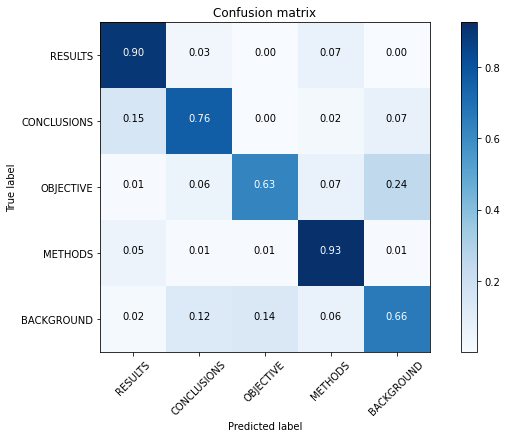

In [20]:
#Get predictions for ACC, F1-Score and CM
pred_test = model.predict(padded_test)
pred_test = tf.argmax(pred_test, axis=1)

f1   = f1_score(test_labels, pred_test, average="weighted")
acc  = accuracy_score(test_labels, pred_test)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))

plot_confusion_matrix(
    test_labels,
    pred_test,
    [*class_to_index],
    normalize=True,
    title="Confusion matrix",
    cmap=plt.cm.Blues)